In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [12]:
import pandas as pd
import configs
import numpy as np

In [13]:
import os
import json

## Create setup dicts
1. Word Unit+Labels: `morph, token, multitok`
1. Char Arch: `char_lstm, char_cnn, no_char`
1. Word Embedding: `ft_tok, ft_yap, ft_tok_oov, ft_yap_oov, w2v_tok, w2v_yap, no_word_embed`

3 x 3 x 7 = **63 dicts**

In [54]:
data_folder = '../NER/data/for_ncrf'

datasets = {
    'morph': {
        '_unit': 'morpheme',
        '_scheme': 'bioes',
        'train_dir': 'morph_gold_train.bmes',
        'dev_dir': 'morph_gold_dev.bmes',
        'test_dir': 'morph_gold_test.bmes', 
    },
    'token': {
        '_unit': 'token',
        '_scheme': 'bioes',
        'train_dir': 'token_gold_train_fix.bmes',
        'dev_dir': 'token_gold_dev_fix.bmes',
        'test_dir': 'token_gold_test_fix.bmes',
    },
    'multitok': {
        '_unit': 'token',
        '_scheme': 'concat_bioes',
        'seg': False,
        'train_dir': 'token_gold_train_concat.bmes',
        'dev_dir': 'token_gold_dev_concat.bmes',
        'test_dir': 'token_gold_test_concat.bmes',
    },
}

In [55]:
default_grid = { 
        # FIXED
        'word_seq_feature': 'LSTM',
        'word_emb_dim': 300,
        'char_emb_dim': 30,
        'iteration': 200,
        'bilstm': True,
        'norm_word_emb': False,
        'norm_char_emb': False,
        'ave_batch_loss': False,
        'use_crf': True,
        'l2': 1e-8,
        'lstm_layer': 2,
        'batch_size': 8,
        'number_normalized': True,
        'optimizer': 'SGD',
        'lr_decay': 0.05,
        'momentum': 0,
        'nbest': 1,
        'hidden_dim': 200,
        'dropout': 0.5,

    }
    
dataset_grids = {
    'multitok': {
        'learning_rate': 0.005,
    },
    'morph': {
        'learning_rate': 0.01,
    },
    'token': {
        'learning_rate': 0.01,
    },
}
arch_grids = {
    'char_lstm': {
        'char_seq_feature': 'LSTM',
        'use_char': True,
        'char_hidden_dim': 70, 
    },
    'char_cnn': {
        'char_seq_feature': 'CNN',
        'use_char': True,
        'char_hidden_dim': 70,
        'char_kernel_size': 7,
    },
    'no_char': {
        'use_char': False,
     },
}


In [56]:
word_embedding_files = {
    'ft_yap': '../wordembedding-hebrew/vectors_alt_tok/wikipedia.alt_tok.yap_form.fasttext_skipgram.model.vec.nofirstline',
    'ft_tok': '../wordembedding-hebrew/vectors_alt_tok/wikipedia.alt_tok.tokenized.fasttext_skipgram.model.vec.nofirstline',
    'ft_oov_yap': 'data/htb_all_words.wikipedia.alt_tok.yap_form.fasttext_skipgram.txt',
    'ft_oov_tok': 'data/htb_all_words.wikipedia.alt_tok.tokenized.fasttext_skipgram.txt',
    #'w2v_yap': '../wordembedding-hebrew/vectors_alt_tok/wikipedia.alt_tok.yap_form.word2vec_skipgram.txt.nofirstline',
    #'w2v_tok': '../wordembedding-hebrew/vectors_alt_tok/wikipedia.alt_tok.tokenized.word2vec_skipgram.txt.nofirstline',
    'glv_yap': '../wordembedding-hebrew/vectors_alt_tok/wikipedia.alt_tok.yap_form.glove.txt',
    'glv_tok': '../wordembedding-hebrew/vectors_alt_tok/wikipedia.alt_tok.tokenized.glove.txt',
    'no_word': None,
}

In [57]:
models_folder = 'final_setup/models'
conf_folder =   'final_setup/conf'
json_folder =   'final_setup/conf_json'
logs_folder =   'final_setup/logs'

In [58]:
seed_num_options = np.arange(44, 54)
seed_num_options

array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53])

In [10]:
def create_conf_dict(model_base_name, dataset, arch, emb_name, seed_num):
    full_conf_dict = {}
    full_conf_dict['status'] = 'train'
    full_conf_dict['model_dir'] = os.path.join(models_folder, model_base_name)
    
    for k, v in datasets[dataset].items():
        if not k.startswith('_'):
            if k in ['train_dir', 'dev_dir', 'test_dir']:
                full_conf_dict[k] = os.path.join(data_folder, v)
            else:
                full_conf_dict[k] = v
    
    if not(emb_name == 'no_word' or word_embedding_files[emb_name] is None):
        full_conf_dict['word_emb_dir'] = word_embedding_files[emb_name]
    
    
    full_conf_dict.update(default_grid)
    full_conf_dict.update(dataset_grids[dataset])
    full_conf_dict.update(arch_grids[arch])
            
    return full_conf_dict
    

In [11]:
confs = {}
for dataset in datasets:
    for arch in arch_grids:
        for emb_name in word_embedding_files:
            for seed_num in seed_num_options:
                model_base_name = '.'.join([dataset, arch, emb_name, str(seed_num)+'_seed'])
                confs[model_base_name] = create_conf_dict(model_base_name, dataset, 
                                                          arch, emb_name, seed_num)
            

In [51]:
len(confs)

630

In [13]:
confs['morph.char_lstm.ft_yap.44_seed']

{'status': 'train',
 'model_dir': 'final_setup/models/morph.char_lstm.ft_yap.44_seed',
 'train_dir': '../NER/data/for_ncrf/morph_gold_train.bmes',
 'dev_dir': '../NER/data/for_ncrf/morph_gold_dev.bmes',
 'test_dir': '../NER/data/for_ncrf/morph_gold_test.bmes',
 'word_emb_dir': '../wordembedding-hebrew/vectors_alt_tok/wikipedia.alt_tok.yap_form.fasttext_skipgram.model.vec.nofirstline',
 'word_seq_feature': 'LSTM',
 'word_emb_dim': 300,
 'char_emb_dim': 30,
 'iteration': 200,
 'bilstm': True,
 'norm_word_emb': False,
 'norm_char_emb': False,
 'ave_batch_loss': False,
 'use_crf': True,
 'l2': 1e-08,
 'lstm_layer': 2,
 'batch_size': 8,
 'number_normalized': True,
 'optimizer': 'SGD',
 'lr_decay': 0.05,
 'momentum': 0,
 'nbest': 1,
 'hidden_dim': 200,
 'dropout': 0.5,
 'learning_rate': 0.01,
 'char_seq_feature': 'LSTM',
 'use_char': True,
 'char_hidden_dim': 70}

In [15]:
import pickle
pickle.dump(confs, open('final_setup/confs.pkl', 'wb'))

## Create conf files for setup dicts
1. Random Seed: 10 different `(44, 45, 46...)`
1. `morph.charlstm.ft_tok.44_seed.conf`
1. `multitok.nochar.no_word_embed.47_seed.conf`

63 * 10 = **630 conf files**

In [16]:
if not os.path.exists(models_folder):
    os.mkdir(models_folder)
if not os.path.exists(conf_folder):
    os.mkdir(conf_folder)
if not os.path.exists(json_folder):
    os.mkdir(json_folder)
if not os.path.exists(logs_folder):
    os.mkdir(logs_folder)

In [17]:
for name, conf in confs.items():
    conf_path = os.path.join(conf_folder, name+'.conf')
    with open(conf_path, 'w', encoding='utf8') as of:
        for k, v in conf.items():
            of.write(k+'='+str(v)+'\n')
    json_path = os.path.join(json_folder, name+'.json')
    with open(json_path, 'w') as of:
        of.write(json.dumps(conf))

## Create `main.X.py` files
Only difference is `seed_num`: 
- `main.44.py` will have `seed_num = 44`

## Create `final_setup_run.py`
1. seed_num match: runs `.conf` files with matching `main.X.py` file **only**.
1. Choose device. 
1. Choose conf prefix.
1. Skip confs that are running or ran already (using `.dset` file)

In [7]:
emb_options = list(word_embedding_files.keys())+[None]
emb_options

['alt_tok_yap_ft_sg',
 'alt_tok_tokenized_ft_sg',
 'htb_all_alt_tok_yap_ft_sg',
 'htb_all_alt_tok_tokenized_ft_sg',
 'alt_tok_yap_w2v_sg',
 'alt_tok_tokenized_w2v_sg',
 None]

## Read logs

In [50]:
import pickle
confs = pickle.load( open('final_setup/confs.pkl', 'rb'))

In [59]:
import re
import os
DEV_RES_LINE = re.compile('Dev: .*; acc: (?P<acc>[^,]+)(?:, p: (?P<p>[^,]+), r: (?P<r>[^,]+), f: (?P<f>[-\d\.]+))?')
#Dev: time: 0.94s speed: 536.09st/s; acc: 0.9043
#Dev: time: 3.42s, speed: 146.59st/s; acc: 0.9546, p: 0.7577, r: 0.6393, f: 0.6935

mtimes = []
res = []
archs = []
for f in os.scandir(logs_folder):
    if f.name.startswith('.ipy'):
        continue
    mtimes.append(os.path.getmtime(f.path))
    model_base_name = '.'.join(f.name.split('.')[:-1])
    model_no_seed = '.'.join(f.name.split('.')[:-2])
    unit, arch, w_embed, seed_num = f.name.split('.')[:-1]
    archs.append(arch)
    matching_conf = confs[model_base_name]
    params = { 'model_base_name': model_base_name, 'arch': arch, 
              'unit': unit, 'w_embed': w_embed, 'seed_num': seed_num,
              'model_no_seed': model_no_seed,}
    params.update(matching_conf)
    with open(f.path, 'r') as fp:
        i= 0
        for line in fp:
            m = DEV_RES_LINE.match(line)
            if m:
                r = m.groupdict().copy()
                for k, v in r.items():
                    if v is not None:
                        r[k] = float(v)
                r.update(params)
                r['epoch'] = i
                i+=1
                res.append(r)

rdf = pd.DataFrame(res)

rdf['model_file_name'] = rdf.model_base_name + '.' + rdf.epoch.astype(str) + '.model'
rdf['dset_file_name'] =  rdf.model_base_name +'.dset'
rdf['char_seq_feature'] = rdf.char_seq_feature.fillna('NoChar')

rdf['relevant_score'] = rdf.f.fillna(rdf.acc)

def get_embed_unit(s):
    if 'yap' in s:
        return 'morph'
    elif 'tok' in s:
        return 'token'
    return 'na'

def get_clash_match(s):
    if s.embed_unit=='na':
        return 'na'
    elif s.embed_unit==s.input_unit:
        return 'Match'
    else:
        return 'Clash'
    
rdf['input_unit'] = rdf.unit.apply(lambda x: 'morph' if x=='morph' else 'token')
rdf['embed_unit'] = rdf.w_embed.apply(get_embed_unit)
rdf['embed_type'] = rdf.w_embed.str.replace('_tok|_yap', '')
rdf['cm'] = rdf.apply(get_clash_match, axis=1)

erdf = rdf[(rdf.groupby(['seed_num', 'arch', 'unit', 'w_embed']).relevant_score.transform(max)==rdf.relevant_score) ]
erdf = erdf[(erdf.groupby(['seed_num', 'arch', 'unit', 'w_embed']).epoch.transform(min)==erdf.epoch) ]

In [60]:
erdf.shape

(630, 49)

In [61]:
erdf.groupby(['unit', 'arch', 'w_embed']).seed_num.nunique().unstack()

w_embed             ft_oov_tok  ft_oov_yap  ft_tok  ft_yap  glv_tok  glv_yap  \
unit     arch                                                                  
morph    char_cnn           10          10      10      10       10       10   
         char_lstm          10          10      10      10       10       10   
         no_char            10          10      10      10       10       10   
multitok char_cnn           10          10      10      10       10       10   
         char_lstm          10          10      10      10       10       10   
         no_char            10          10      10      10       10       10   
token    char_cnn           10          10      10      10       10       10   
         char_lstm          10          10      10      10       10       10   
         no_char            10          10      10      10       10       10   

w_embed             no_word  
unit     arch                
morph    char_cnn        10  
         char_lstm       10  
         no_char         10  
multitok char_cnn        10  
         char_lstm       10  
         no_char         10  
token    char_cnn        10  
         char_lstm       10  
         no_char         10

In [1214]:
print ('Mean time per run:', round((max(mtimes) - min(mtimes) )/ len(mtimes) / 60, 2), 'minutes')

Mean time per run: 7.15 minutes


In [1215]:
erdf.groupby(['unit', 'arch', 'embed_type', 'cm']).relevant_score.mean().unstack([-2,-1]).mul(100).round(2)

embed_type             ft        ft_oov           glv        no_word
cm                  Clash  Match  Clash  Match  Clash  Match      na
unit     arch                                                       
morph    char_cnn   79.39  78.91  79.70  80.03  77.89  78.00   63.02
         char_lstm  78.79  78.72  79.42  79.76  77.87  78.62   62.85
         no_char    78.57  77.96  79.70  79.71  76.38  76.42   59.76
multitok char_cnn   92.58  93.92  93.23  94.26  92.39  93.36   88.69
         char_lstm  92.62  93.88  93.19  94.25  92.28  93.33   88.87
         no_char    91.33  92.74  90.27  93.55  90.57  90.49   82.52
token    char_cnn   70.45  75.80  75.97  78.35  69.00  74.20   56.38
         char_lstm  70.73  76.77  75.67  78.12  69.36  74.12   56.39
         no_char    69.10  74.72  74.76  77.40  66.42  71.24   52.83

In [24]:
import numpy as np 
def perc(n):
    def perc_(x):
        return np.percentile(x, n)
    perc_.__name__ = 'perc_%s' % n
    return perc_

In [1216]:
erdf.groupby(['unit', 'char_seq_feature']).relevant_score.agg(['max', 'min', 'mean', 'std', 'median', perc(95)]).mul(100).round(2)

max    min   mean   std  median  perc_95
unit     char_seq_feature                                            
morph    CNN               80.68  62.08  76.71  5.70   78.84    80.53
         LSTM              80.90  61.34  76.58  5.71   78.70    80.24
         NoChar            80.94  58.71  75.50  6.62   77.82    80.09
multitok CNN               94.40  88.50  92.63  1.74   93.18    94.27
         LSTM              94.37  88.70  92.63  1.68   93.16    94.29
         NoChar            93.73  81.78  90.21  3.37   90.66    93.57
token    CNN               79.16  55.43  71.45  6.92   74.08    78.42
         LSTM              78.65  55.33  71.60  6.94   74.28    78.40
         NoChar            77.97  50.90  69.50  7.71   70.97    77.60

In [1217]:
erdf.to_pickle('final_setup/erdf.pkl')

## Decode

In [18]:
output_folder = 'final_setup/decode_output'
decode_conf_folder = 'final_setup/decode_conf'

In [19]:
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

if not os.path.exists(decode_conf_folder):
    os.mkdir(decode_conf_folder)
    
decode_sets = {
    'morph': {
        'morph_dev_gold': '../NER/data/for_ncrf/morph_gold_dev.bmes',
        'morph_dev_yap': '../NER/data/for_ncrf/morph_yap_dev_dummy_o.bmes',
        'morph_test_gold': '../NER/data/for_ncrf/morph_gold_test.bmes',
        'morph_test_yap': '../NER/data/for_ncrf/morph_yap_test_dummy_o.bmes',
    },
    'token': {
        'token_dev': '../NER/data/for_ncrf/token_gold_dev_fix.bmes',
        'token_test': '../NER/data/for_ncrf/token_gold_test_fix.bmes',
    },
    'multitok': {
        'token_dev': '../NER/data/for_ncrf/token_gold_dev_concat.bmes',
        'token_test': '../NER/data/for_ncrf/token_gold_test_concat.bmes',
    }
}

In [1218]:
params = { 'status': 'decode' }

for i, row in erdf.iterrows():
    unit = row['unit']
    for name, set_path in decode_sets[unit].items():
        row_par = params.copy()
        row_par['load_model_dir'] = os.path.join(models_folder, row['model_file_name'])
        row_par['dset_dir'] = os.path.join(models_folder, row['dset_file_name'])
        row_par['decode_dir'] = os.path.join(output_folder, name+'.'+row['model_base_name']+'.bmes')
        row_par['raw_dir'] = set_path
        
        conf_path = os.path.join(decode_conf_folder, name+'.'+row['model_base_name']+'.decode.conf')
        if not os.path.exists(conf_path):
            with open(conf_path, 'w', encoding='utf8') as of:
                for k, v in row_par.items():
                    of.write(k+'='+str(v)+'\n')        
 

In [2]:
import os, re

In [3]:
pred_line = re.compile('Predict raw 1-best result has been written into file.*')
bads = []
for f in os.scandir('final_setup/decode_logs2'):
    if f.name=='.ipynb_checkpoints' or f.name=='.log':
        continue
    with open(f.path, 'r') as fp:
        data = fp.read()
        if len(re.findall(pred_line, data))==0:
            bads.append (f.name)
            os.remove(f.path)
sorted(bads)

[]

In [4]:
from collections import Counter

In [48]:
xxx = []
for f in os.scandir('final_setup/decode_output'):
    if f.name=='.ipynb_checkpoints' or f.name=='.bmes':
        continue
    elif 'pruned' in f.name:
        xxx.append('.'.join(f.name.split('.')[:-2]))
Counter(xxx).most_common()

[('morph_dev_pruned.morph.char_cnn.ft_oov_tok', 10),
 ('morph_dev_pruned.morph.no_char.ft_oov_tok', 10),
 ('morph_dev_pruned.morph.no_char.ft_oov_yap', 10),
 ('morph_dev_pruned.morph.no_char.ft_tok', 10),
 ('morph_dev_pruned.morph.no_char.ft_yap', 10),
 ('morph_dev_pruned.morph.no_char.glv_tok', 10),
 ('morph_dev_pruned.morph.no_char.glv_yap', 10),
 ('morph_dev_pruned.morph.no_char.no_word', 10),
 ('morph_dev_pruned.morph.char_cnn.ft_oov_yap', 10),
 ('morph_test_pruned.morph.char_cnn.ft_oov_tok', 10),
 ('morph_test_pruned.morph.char_cnn.ft_oov_yap', 10),
 ('morph_test_pruned.morph.char_cnn.ft_tok', 10),
 ('morph_test_pruned.morph.char_cnn.ft_yap', 10),
 ('morph_test_pruned.morph.char_cnn.glv_tok', 10),
 ('morph_test_pruned.morph.char_cnn.glv_yap', 10),
 ('morph_test_pruned.morph.char_cnn.no_word', 10),
 ('morph_test_pruned.morph.char_lstm.ft_oov_tok', 10),
 ('morph_test_pruned.morph.char_lstm.ft_oov_yap', 10),
 ('morph_test_pruned.morph.char_lstm.ft_tok', 10),
 ('morph_test_pruned.morp

## Evaluate decoded folder

In [14]:
erdf = pd.read_pickle('final_setup/erdf.pkl')

In [15]:
import sys
sys.path.append('../NER')
import ne_evaluate_mentions as nem

In [17]:
scores = {}

In [1319]:
if os.path.exists('final_setup/scores.pkl'):
    scores = pickle.load(open('final_setup/scores.pkl', 'rb'))

In [35]:
for file in os.scandir(output_folder):
    if file.name=='.ipynb_checkpoints':
        continue
    gold_name, inp, arch, w_embed, seed_num = file.name.split('.')[:-1]
    if (gold_name, inp, arch, w_embed, seed_num) not in scores:
        if len(gold_name.split('_'))>2:
            unit, pred_set, _ = gold_name.split('_')
            gold_path = decode_sets[unit][unit+'_'+pred_set+'_gold']
        else:
            unit, pred_set = gold_name.split('_')
            gold_path = decode_sets[unit][unit+'_'+pred_set]
        p, r, f = nem.evaluate_files(gold_path, file)
        scores[(gold_name, inp, arch, w_embed, seed_num)] = (p, r, f)
    

In [36]:
import pickle
pickle.dump(scores, open('final_setup/scores2.pkl', 'wb'))

In [62]:
score_tups = [(*k, *v) for k,v in scores.items()]

In [63]:
mev = pd.DataFrame(score_tups, columns=('gold_name', 'unit', 'arch', 
                                        'w_embed', 'seed_num', 
                                        'p_m', 'r_m', 'f_m'))
(mev[mev.gold_name.str.contains('dev')].groupby(['gold_name', 'unit', 'arch'])
 .f_m.agg(['max', 'min', 'mean', 'std', 'median', perc(95)]))

max       min      mean       std  \
gold_name        unit     arch                                                
morph_dev_gold   morph    char_cnn   0.806830  0.620773  0.767274  0.056930   
                          char_lstm  0.809829  0.614118  0.766029  0.056991   
                          no_char    0.809372  0.587796  0.755272  0.066165   
morph_dev_pruned morph    char_cnn   0.788584  0.582927  0.741672  0.062661   
                          char_lstm  0.796555  0.577830  0.739673  0.062029   
                          no_char    0.781876  0.544061  0.727769  0.072962   
morph_dev_yap    morph    char_cnn   0.737740  0.558252  0.692242  0.052256   
                          char_lstm  0.737527  0.555024  0.690014  0.050185   
                          no_char    0.737527  0.526582  0.682518  0.060684   
token_dev        multitok char_cnn   0.779193  0.540201  0.707866  0.068994   
                          char_lstm  0.785639  0.538071  0.710095  0.069555   
                          no_char    0.795789  0.467811  0.686161  0.090618   
                 token    char_cnn   0.791579  0.554307  0.714809  0.069359   
                          char_lstm  0.787368  0.553299  0.716190  0.069472   
                          no_char    0.779661  0.509603  0.695219  0.077213   

                                       median   perc_95  
gold_name        unit     arch                           
morph_dev_gold   morph    char_cnn   0.788462  0.805329  
                          char_lstm  0.787123  0.802357  
                          no_char    0.778190  0.801265  
morph_dev_pruned morph    char_cnn   0.764520  0.785235  
                          char_lstm  0.762613  0.783816  
                          no_char    0.752815  0.778265  
morph_dev_yap    morph    char_cnn   0.710569  0.733230  
                          char_lstm  0.707463  0.726625  
                          no_char    0.702264  0.728002  
token_dev        multitok char_cnn   0.724617  0.771131  
                          char_lstm  0.729105  0.778849  
                          no_char    0.709351  0.784853  
                 token    char_cnn   0.741185  0.784233  
                          char_lstm  0.742735  0.783976  
                          no_char    0.710094  0.775939

In [64]:
(mev[mev.gold_name.str.contains('dev')].groupby(['gold_name', 'unit', 'arch']).size())

gold_name         unit      arch     
morph_dev_gold    morph     char_cnn     70
                            char_lstm    70
                            no_char      70
morph_dev_pruned  morph     char_cnn     70
                            char_lstm    70
                            no_char      70
morph_dev_yap     morph     char_cnn     70
                            char_lstm    70
                            no_char      70
token_dev         multitok  char_cnn     70
                            char_lstm    70
                            no_char      70
                  token     char_cnn     70
                            char_lstm    70
                            no_char      70
dtype: int64

In [65]:
mev.head()

,gold_name,unit,arch,w_embed,seed_num,p_m,r_m,f_m
0,morph_dev_gold,morph,char_cnn,ft_yap,44_seed,0.859155,0.733467,0.791351
1,morph_dev_yap,morph,char_cnn,ft_yap,44_seed,0.780193,0.647295,0.707558
2,morph_test_gold,morph,char_cnn,ft_yap,44_seed,0.804850,0.747854,0.775306
3,morph_dev_gold,morph,char_cnn,ft_oov_tok,44_seed,0.843612,0.767535,0.803778
4,morph_test_yap,morph,char_cnn,ft_yap,44_seed,0.721411,0.636266,0.676169


In [66]:
mev['pred_set'] = mev.gold_name.apply(lambda x: '_'.join(x.split('_')[1:]))

In [67]:
mev = mev.merge(erdf, how='left')

In [173]:
mev[(mev.gold_name=='token_dev') & (abs(mev.f-mev.f_m)>0.001)]

,gold_name,unit,arch,w_embed,seed_num,p_m,r_m,f_m,pred_set,acc,p,r,f,model_base_name,model_no_seed,...,char_seq_feature,use_char,char_hidden_dim,char_kernel_size,epoch,seg,model_file_name,dset_file_name,relevant_score,input_unit,embed_unit,embed_type,cm,pred_set_sub,pred_set_main
383,token_dev,token,no_char,ft_tok,45_seed,0.808858,0.695391,0.747845,dev,0.9637,0.8051,0.6954,0.7462,token.no_char.ft_tok.45_seed,token.no_char.ft_tok,...,NoChar,False,NaN,NaN,50,NaN,token.no_char.ft_tok.45_seed.50.model,token.no_char.ft_tok.45_seed.dset,0.7462,token,token,ft,Match,,dev
417,token_dev,token,no_char,glv_yap,45_seed,0.772727,0.579158,0.662085,dev,0.9522,0.7733,0.5812,0.6636,token.no_char.glv_yap.45_seed,token.no_char.glv_yap,...,NoChar,False,NaN,NaN,89,NaN,token.no_char.glv_yap.45_seed.89.model,token.no_char.glv_yap.45_seed.dset,0.6636,token,morph,glv,Clash,,dev
458,token_dev,token,no_char,glv_tok,46_seed,0.763889,0.661323,0.708915,dev,0.9578,0.7604,0.6613,0.7074,token.no_char.glv_tok.46_seed,token.no_char.glv_tok,...,NoChar,False,NaN,NaN,134,NaN,token.no_char.glv_tok.46_seed.134.model,token.no_char.glv_tok.46_seed.dset,0.7074,token,token,glv,Match,,dev
476,token_dev,token,char_lstm,ft_tok,46_seed,0.835681,0.713427,0.769730,dev,0.9661,0.8318,0.7134,0.7681,token.char_lstm.ft_tok.46_seed,token.char_lstm.ft_tok,...,LSTM,True,70.0,NaN,145,NaN,token.char_lstm.ft_tok.46_seed.145.model,token.char_lstm.ft_tok.46_seed.dset,0.7681,token,token,ft,Match,,dev
1028,token_dev,token,no_char,glv_yap,49_seed,0.769841,0.583166,0.663626,dev,0.9518,0.7704,0.5852,0.6651,token.no_char.glv_yap.49_seed,token.no_char.glv_yap,...,NoChar,False,NaN,NaN,97,NaN,token.no_char.glv_yap.49_seed.97.model,token.no_char.glv_yap.49_seed.dset,0.6651,token,morph,glv,Clash,,dev
1096,token_dev,token,no_char,glv_yap,50_seed,0.779528,0.595190,0.675000,dev,0.9537,0.7801,0.5972,0.6765,token.no_char.glv_yap.50_seed,token.no_char.glv_yap,...,NoChar,False,NaN,NaN,136,NaN,token.no_char.glv_yap.50_seed.136.model,token.no_char.glv_yap.50_seed.dset,0.6765,token,morph,glv,Clash,,dev
1386,token_dev,token,char_cnn,glv_yap,53_seed,0.776382,0.619238,0.688963,dev,0.9556,0.7769,0.6212,0.6904,token.char_cnn.glv_yap.53_seed,token.char_cnn.glv_yap,...,CNN,True,70.0,7.0,164,NaN,token.char_cnn.glv_yap.53_seed.164.model,token.char_cnn.glv_yap.53_seed.dset,0.6904,token,morph,glv,Clash,,dev
1650,token_dev,token,char_cnn,ft_oov_yap,51_seed,0.818391,0.713427,0.762313,dev,0.9645,0.8146,0.7134,0.7607,token.char_cnn.ft_oov_yap.51_seed,token.char_cnn.ft_oov_yap,...,CNN,True,70.0,7.0,174,NaN,token.char_cnn.ft_oov_yap.51_seed.174.model,token.char_cnn.ft_oov_yap.51_seed.dset,0.7607,token,morph,ft_oov,Clash,,dev


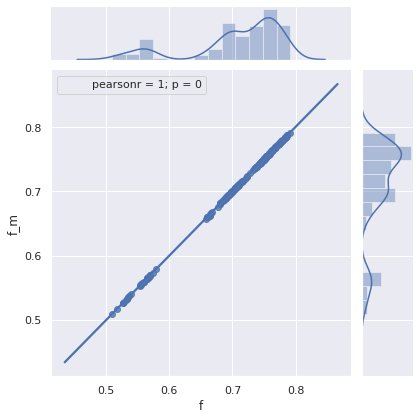

In [172]:
import seaborn as sns
import scipy.stats as stats

sns.set(style="darkgrid", color_codes=True)
j = sns.jointplot(mev[mev.gold_name=='token_dev'].f, mev[mev.gold_name=='token_dev'].f_m, kind='reg')
j.annotate(stats.pearsonr)
plt.show()

In [68]:
(mev[mev.pred_set.str.contains('dev')].groupby(['unit', 'pred_set', 'arch', 'embed_type', 'cm'])
 .f_m.agg(['mean', 'std']).mul(100).round(2)
 .assign(mean = lambda x: x['mean'].apply('{:,.2f}'.format).astype(str)+' ± '+ x['std'].round(1).astype(str))[['mean']]
 .unstack([-2,-1]))


mean                            \
embed_type                              ft                    ft_oov   
cm                                   Clash        Match        Clash   
unit     pred_set   arch                                               
morph    dev_gold   char_cnn   79.39 ± 0.5  78.92 ± 0.4  79.72 ± 0.6   
                    char_lstm  78.81 ± 0.6  78.73 ± 0.6  79.43 ± 0.6   
                    no_char    78.59 ± 0.7  77.96 ± 0.6  79.75 ± 0.5   
         dev_pruned char_cnn   76.23 ± 0.6  76.88 ± 0.4  77.55 ± 0.8   
                    char_lstm  75.55 ± 0.7  76.66 ± 0.8  76.89 ± 0.6   
                    no_char    75.48 ± 0.8  76.25 ± 0.6  77.53 ± 0.5   
         dev_yap    char_cnn   71.59 ± 0.7  71.10 ± 0.3  72.34 ± 1.0   
                    char_lstm  70.84 ± 0.9  70.55 ± 0.8  71.74 ± 0.7   
                    no_char    70.93 ± 0.8  70.48 ± 0.7  72.01 ± 0.6   
multitok dev        char_cnn   70.94 ± 0.7  74.86 ± 0.4  75.09 ± 0.7   
                    char_lstm  71.49 ± 1.0  75.12 ± 0.8  75.59 ± 1.0   
                    no_char    68.45 ± 0.6  74.73 ± 0.8  73.96 ± 0.9   
token    dev        char_cnn   70.49 ± 0.6  75.83 ± 0.6  76.01 ± 0.5   
                    char_lstm  70.77 ± 0.7  76.82 ± 0.5  75.69 ± 0.7   
                    no_char    69.16 ± 0.6  74.78 ± 0.6  74.80 ± 0.6   

                                                                      \
embed_type                                          glv                
cm                                   Match        Clash        Match   
unit     pred_set   arch                                               
morph    dev_gold   char_cnn   80.03 ± 0.7  77.93 ± 0.4  78.04 ± 0.5   
                    char_lstm  79.81 ± 0.7  77.89 ± 0.6  78.65 ± 0.8   
                    no_char    79.75 ± 0.7  76.40 ± 0.5  76.43 ± 0.7   
         dev_pruned char_cnn   78.13 ± 0.7  75.18 ± 0.7  76.03 ± 0.5   
                    char_lstm  78.18 ± 0.7  74.89 ± 1.0  76.39 ± 1.2   
                    no_char    77.00 ± 0.6  73.91 ± 0.6  73.88 ± 1.0   
         dev_yap    char_cnn   72.59 ± 0.8  70.14 ± 0.7  69.99 ± 0.6   
                    char_lstm  72.37 ± 0.7  69.93 ± 1.0  70.46 ± 0.9   
                    no_char    72.57 ± 0.9  69.03 ± 0.5  68.80 ± 1.0   
multitok dev        char_cnn   77.04 ± 0.6  69.80 ± 1.0  72.69 ± 0.8   
                    char_lstm  77.59 ± 0.7  68.95 ± 1.0  72.79 ± 0.9   
                    no_char    78.12 ± 0.9  65.47 ± 1.0  70.70 ± 1.3   
token    dev        char_cnn   78.38 ± 0.4  69.03 ± 0.6  74.27 ± 0.7   
                    char_lstm  78.15 ± 0.5  69.36 ± 0.9  74.13 ± 0.7   
                    no_char    77.41 ± 0.4  66.38 ± 0.5  71.28 ± 0.7   

                                            
embed_type                         no_word  
cm                                      na  
unit     pred_set   arch                    
morph    dev_gold   char_cnn   63.06 ± 0.6  
                    char_lstm  62.91 ± 0.9  
                    no_char    59.81 ± 0.5  
         dev_pruned char_cnn   59.16 ± 0.6  
                    char_lstm  59.21 ± 1.1  
                    no_char    55.40 ± 0.6  
         dev_yap    char_cnn   56.82 ± 0.6  
                    char_lstm  57.12 ± 1.1  
                    no_char    53.95 ± 0.7  
multitok dev        char_cnn   55.09 ± 0.6  
                    char_lstm  55.53 ± 0.9  
                    no_char    48.87 ± 1.2  
token    dev        char_cnn   56.38 ± 0.6  
                    char_lstm  56.41 ± 0.8  
                    no_char    52.85 ± 0.9

In [69]:
x = (mev[mev.pred_set.str.contains('dev')].groupby(['unit', 'pred_set', 'arch', 'embed_type', 'cm'])
 .f_m.agg([ 'mean', 'std']).mul(100).round(2)
 .assign(std = lambda x: x['std'].round(1))
 .unstack([-2,-1]))
x.columns = x.columns.reorder_levels([1,2,0])
pd.set_option("max_columns", 30)
x.sort_index(axis=1)


embed_type                        ft                  ft_oov                   \
cm                             Clash       Match       Clash       Match        
                                mean  std   mean  std   mean  std   mean  std   
unit     pred_set   arch                                                        
morph    dev_gold   char_cnn   79.39  0.5  78.92  0.4  79.72  0.6  80.03  0.7   
                    char_lstm  78.81  0.6  78.73  0.6  79.43  0.6  79.81  0.7   
                    no_char    78.59  0.7  77.96  0.6  79.75  0.5  79.75  0.7   
         dev_pruned char_cnn   76.23  0.6  76.88  0.4  77.55  0.8  78.13  0.7   
                    char_lstm  75.55  0.7  76.66  0.8  76.89  0.6  78.18  0.7   
                    no_char    75.48  0.8  76.25  0.6  77.53  0.5  77.00  0.6   
         dev_yap    char_cnn   71.59  0.7  71.10  0.3  72.34  1.0  72.59  0.8   
                    char_lstm  70.84  0.9  70.55  0.8  71.74  0.7  72.37  0.7   
                    no_char    70.93  0.8  70.48  0.7  72.01  0.6  72.57  0.9   
multitok dev        char_cnn   70.94  0.7  74.86  0.4  75.09  0.7  77.04  0.6   
                    char_lstm  71.49  1.0  75.12  0.8  75.59  1.0  77.59  0.7   
                    no_char    68.45  0.6  74.73  0.8  73.96  0.9  78.12  0.9   
token    dev        char_cnn   70.49  0.6  75.83  0.6  76.01  0.5  78.38  0.4   
                    char_lstm  70.77  0.7  76.82  0.5  75.69  0.7  78.15  0.5   
                    no_char    69.16  0.6  74.78  0.6  74.80  0.6  77.41  0.4   

embed_type                       glv                  no_word       
cm                             Clash       Match           na       
                                mean  std   mean  std    mean  std  
unit     pred_set   arch                                            
morph    dev_gold   char_cnn   77.93  0.4  78.04  0.5   63.06  0.6  
                    char_lstm  77.89  0.6  78.65  0.8   62.91  0.9  
                    no_char    76.40  0.5  76.43  0.7   59.81  0.5  
         dev_pruned char_cnn   75.18  0.7  76.03  0.5   59.16  0.6  
                    char_lstm  74.89  1.0  76.39  1.2   59.21  1.1  
                    no_char    73.91  0.6  73.88  1.0   55.40  0.6  
         dev_yap    char_cnn   70.14  0.7  69.99  0.6   56.82  0.6  
                    char_lstm  69.93  1.0  70.46  0.9   57.12  1.1  
                    no_char    69.03  0.5  68.80  1.0   53.95  0.7  
multitok dev        char_cnn   69.80  1.0  72.69  0.8   55.09  0.6  
                    char_lstm  68.95  1.0  72.79  0.9   55.53  0.9  
                    no_char    65.47  1.0  70.70  1.3   48.87  1.2  
token    dev        char_cnn   69.03  0.6  74.27  0.7   56.38  0.6  
                    char_lstm  69.36  0.9  74.13  0.7   56.41  0.8  
                    no_char    66.38  0.5  71.28  0.7   52.85  0.9

In [70]:
mev[(mev.unit=='morph') & (mev.pred_set.str.contains('pruned')) & (mev.embed_type=='ft_oov') & (mev.arch=='char_cnn')].groupby(['pred_set','cm']).f_m.mean().unstack()

cm,Clash,Match
pred_set,,
dev_pruned,0.775500,0.781282
test_pruned,0.760494,0.767517


In [71]:
mev['pred_set_sub'] = mev.pred_set.apply(lambda x: x.split('_')[1] if '_' in x else '')
mev['pred_set_main'] = mev.pred_set.apply(lambda x: x.split('_')[0] )
(mev[((mev.unit!='morph') & (mev.embed_type=='ft_oov') 
    & (mev.arch=='char_cnn')) 
    |
     ((mev.unit=='morph') 
       & (mev.embed_type=='ft_oov') 
      & (mev.arch=='char_cnn'))].groupby(['unit', 'pred_set_sub', 'cm', 'pred_set_main',])
 .f_m.mean().unstack().mul(100).round(2)
 .assign(ratio = lambda x: (x.test/x.dev -1).mul(100).round(1)))

pred_set_main                  dev   test  ratio
unit     pred_set_sub cm                        
morph    gold         Clash  79.72  79.30   -0.5
                      Match  80.03  79.10   -1.2
         pruned       Clash  77.55  76.05   -1.9
                      Match  78.13  76.75   -1.8
         yap          Clash  72.34  69.52   -3.9
                      Match  72.59  69.29   -4.5
multitok              Clash  75.09  75.64    0.7
                      Match  77.04  77.91    1.1
token                 Clash  76.01  75.22   -1.0
                      Match  78.38  77.48   -1.1

In [72]:
mev.to_pickle('final_setup/mev2.pkl')

In [80]:
import os
from collections import defaultdict
for d in os.scandir('hp_search'):
    if d.name.startswith('models'):
        all_models_paths = defaultdict(list)
        all_models_epoch = defaultdict(lambda: -1)
        for f in os.scandir(d.path):
            if f.name!='.model' and f.name.endswith('.model'):
                a, c, _, e, _ = f.name.split('.')
                e = int(e)
                all_models_epoch[(a,c)] = max(alL_models_epoch[(a,c)], e)
                all_models_paths[(a,c)].append((e, f.path))
        for k, v in all_models_paths.items():
            for e, path in v:
                if e!=all_models_epoch[k]:
                    #os.remove(path)

        


## Eval with ignore category

In [81]:
scores = {}

In [82]:
if os.path.exists('final_setup/scores_nocat.pkl'):
    scores = pickle.load(open('final_setup/scores_nocat.pkl', 'rb'))

In [84]:
for file in os.scandir(output_folder):
    if file.name=='.ipynb_checkpoints':
        continue
    gold_name, inp, arch, w_embed, seed_num = file.name.split('.')[:-1]
    if (gold_name, inp, arch, w_embed, seed_num) not in scores:
        if len(gold_name.split('_'))>2:
            unit, pred_set, _ = gold_name.split('_')
            gold_path = decode_sets[unit][unit+'_'+pred_set+'_gold']
        else:
            unit, pred_set = gold_name.split('_')
            gold_path = decode_sets[unit][unit+'_'+pred_set]
        p, r, f = nem.evaluate_files(gold_path, file, ignore_cat=True)
        scores[(gold_name, inp, arch, w_embed, seed_num)] = (p, r, f)
    

In [85]:
import pickle
pickle.dump(scores, open('final_setup/scores_nocat.pkl', 'wb'))

In [86]:
score_tups = [(*k, *v) for k,v in scores.items()]

In [90]:
mev_nocat = pd.DataFrame(score_tups, columns=('gold_name', 'unit', 'arch', 
                                        'w_embed', 'seed_num', 
                                        'p_m', 'r_m', 'f_m'))

In [91]:
(mev_nocat[mev_nocat.gold_name.str.contains('dev')].groupby(['gold_name', 'unit', 'arch']).size())

gold_name         unit      arch     
morph_dev_gold    morph     char_cnn     70
                            char_lstm    70
                            no_char      70
morph_dev_pruned  morph     char_cnn     70
                            char_lstm    70
                            no_char      70
morph_dev_yap     morph     char_cnn     70
                            char_lstm    70
                            no_char      70
token_dev         multitok  char_cnn     70
                            char_lstm    70
                            no_char      70
                  token     char_cnn     70
                            char_lstm    70
                            no_char      70
dtype: int64

In [92]:
mev_nocat['pred_set'] = mev_nocat.gold_name.apply(lambda x: '_'.join(x.split('_')[1:]))

In [93]:
mev_nocat = mev_nocat.merge(erdf, how='left')

In [94]:
(mev_nocat[mev_nocat.pred_set.str.contains('dev')].groupby(['unit', 'pred_set', 'arch', 'embed_type', 'cm'])
 .f_m.agg(['mean', 'std']).mul(100).round(2)
 .assign(mean = lambda x: x['mean'].apply('{:,.2f}'.format).astype(str)+' ± '+ x['std'].round(1).astype(str))[['mean']]
 .unstack([-2,-1]))


mean                            \
embed_type                              ft                    ft_oov   
cm                                   Clash        Match        Clash   
unit     pred_set   arch                                               
morph    dev_gold   char_cnn   83.85 ± 1.6  83.16 ± 1.6  84.72 ± 1.7   
                    char_lstm  83.21 ± 1.7  83.74 ± 0.7  84.87 ± 0.7   
                    no_char    82.79 ± 1.3  82.60 ± 0.7  84.73 ± 1.7   
         dev_pruned char_cnn   80.96 ± 0.6  81.46 ± 0.7  82.62 ± 0.8   
                    char_lstm  80.23 ± 0.7  81.47 ± 0.8  81.64 ± 0.5   
                    no_char    79.38 ± 0.7  80.55 ± 0.6  82.78 ± 0.4   
         dev_yap    char_cnn   76.05 ± 1.8  75.43 ± 1.8  77.04 ± 1.6   
                    char_lstm  75.19 ± 2.0  75.53 ± 0.6  77.03 ± 0.8   
                    no_char    75.09 ± 1.3  75.05 ± 0.8  76.79 ± 1.7   
multitok dev        char_cnn   76.93 ± 0.8  79.24 ± 2.0  79.50 ± 2.2   
                    char_lstm  75.42 ± 2.1  79.31 ± 2.0  79.80 ± 2.1   
                    no_char    73.61 ± 0.6  79.97 ± 0.8  78.89 ± 0.9   
token    dev        char_cnn   75.59 ± 0.8  80.01 ± 1.6  80.40 ± 0.6   
                    char_lstm  75.22 ± 0.8  80.92 ± 0.7  79.75 ± 0.7   
                    no_char    72.96 ± 0.8  78.71 ± 0.8  78.55 ± 0.5   

                                                                      \
embed_type                                          glv                
cm                                   Match        Clash        Match   
unit     pred_set   arch                                               
morph    dev_gold   char_cnn   84.62 ± 1.5  83.37 ± 1.9  82.56 ± 1.7   
                    char_lstm  84.33 ± 2.1  83.59 ± 2.5  83.50 ± 0.7   
                    no_char    84.38 ± 2.0  81.65 ± 0.4  80.46 ± 1.8   
         dev_pruned char_cnn   83.14 ± 0.8  80.59 ± 1.0  80.77 ± 0.7   
                    char_lstm  83.24 ± 0.7  80.83 ± 0.7  81.19 ± 0.6   
                    no_char    81.98 ± 0.5  78.70 ± 0.6  78.24 ± 0.9   
         dev_yap    char_cnn   76.92 ± 1.7  75.44 ± 2.1  74.44 ± 1.6   
                    char_lstm  76.85 ± 1.9  75.51 ± 2.5  75.08 ± 0.6   
                    no_char    77.02 ± 2.3  74.18 ± 0.5  73.09 ± 1.0   
multitok dev        char_cnn   81.24 ± 2.9  75.30 ± 2.2  78.05 ± 3.3   
                    char_lstm  82.51 ± 2.3  75.56 ± 0.7  78.08 ± 2.9   
                    no_char    83.44 ± 0.8  70.81 ± 1.0  76.68 ± 1.5   
token    dev        char_cnn   83.12 ± 0.8  74.52 ± 1.2  79.89 ± 0.9   
                    char_lstm  82.68 ± 0.6  74.32 ± 0.7  80.03 ± 0.9   
                    no_char    81.87 ± 0.6  70.33 ± 0.6  76.73 ± 0.7   

                                            
embed_type                         no_word  
cm                                      na  
unit     pred_set   arch                    
morph    dev_gold   char_cnn   68.29 ± 1.0  
                    char_lstm  67.94 ± 0.7  
                    no_char    64.06 ± 1.0  
         dev_pruned char_cnn   63.68 ± 0.8  
                    char_lstm  63.96 ± 0.7  
                    no_char    58.95 ± 0.6  
         dev_yap    char_cnn   61.82 ± 1.0  
                    char_lstm  61.75 ± 0.7  
                    no_char    58.17 ± 1.0  
multitok dev        char_cnn   58.91 ± 2.7  
                    char_lstm  60.91 ± 1.6  
                    no_char    54.35 ± 1.0  
token    dev        char_cnn   60.61 ± 1.1  
                    char_lstm  60.94 ± 1.4  
                    no_char    55.87 ± 1.0

In [95]:
x = (mev_nocat[mev_nocat.pred_set.str.contains('dev')].groupby(['unit', 'pred_set', 'arch', 'embed_type', 'cm'])
 .f_m.agg([ 'mean', 'std']).mul(100).round(2)
 .assign(std = lambda x: x['std'].round(1))
 .unstack([-2,-1]))
x.columns = x.columns.reorder_levels([1,2,0])
pd.set_option("max_columns", 30)
x.sort_index(axis=1)


embed_type                        ft                  ft_oov                   \
cm                             Clash       Match       Clash       Match        
                                mean  std   mean  std   mean  std   mean  std   
unit     pred_set   arch                                                        
morph    dev_gold   char_cnn   83.85  1.6  83.16  1.6  84.72  1.7  84.62  1.5   
                    char_lstm  83.21  1.7  83.74  0.7  84.87  0.7  84.33  2.1   
                    no_char    82.79  1.3  82.60  0.7  84.73  1.7  84.38  2.0   
         dev_pruned char_cnn   80.96  0.6  81.46  0.7  82.62  0.8  83.14  0.8   
                    char_lstm  80.23  0.7  81.47  0.8  81.64  0.5  83.24  0.7   
                    no_char    79.38  0.7  80.55  0.6  82.78  0.4  81.98  0.5   
         dev_yap    char_cnn   76.05  1.8  75.43  1.8  77.04  1.6  76.92  1.7   
                    char_lstm  75.19  2.0  75.53  0.6  77.03  0.8  76.85  1.9   
                    no_char    75.09  1.3  75.05  0.8  76.79  1.7  77.02  2.3   
multitok dev        char_cnn   76.93  0.8  79.24  2.0  79.50  2.2  81.24  2.9   
                    char_lstm  75.42  2.1  79.31  2.0  79.80  2.1  82.51  2.3   
                    no_char    73.61  0.6  79.97  0.8  78.89  0.9  83.44  0.8   
token    dev        char_cnn   75.59  0.8  80.01  1.6  80.40  0.6  83.12  0.8   
                    char_lstm  75.22  0.8  80.92  0.7  79.75  0.7  82.68  0.6   
                    no_char    72.96  0.8  78.71  0.8  78.55  0.5  81.87  0.6   

embed_type                       glv                  no_word       
cm                             Clash       Match           na       
                                mean  std   mean  std    mean  std  
unit     pred_set   arch                                            
morph    dev_gold   char_cnn   83.37  1.9  82.56  1.7   68.29  1.0  
                    char_lstm  83.59  2.5  83.50  0.7   67.94  0.7  
                    no_char    81.65  0.4  80.46  1.8   64.06  1.0  
         dev_pruned char_cnn   80.59  1.0  80.77  0.7   63.68  0.8  
                    char_lstm  80.83  0.7  81.19  0.6   63.96  0.7  
                    no_char    78.70  0.6  78.24  0.9   58.95  0.6  
         dev_yap    char_cnn   75.44  2.1  74.44  1.6   61.82  1.0  
                    char_lstm  75.51  2.5  75.08  0.6   61.75  0.7  
                    no_char    74.18  0.5  73.09  1.0   58.17  1.0  
multitok dev        char_cnn   75.30  2.2  78.05  3.3   58.91  2.7  
                    char_lstm  75.56  0.7  78.08  2.9   60.91  1.6  
                    no_char    70.81  1.0  76.68  1.5   54.35  1.0  
token    dev        char_cnn   74.52  1.2  79.89  0.9   60.61  1.1  
                    char_lstm  74.32  0.7  80.03  0.9   60.94  1.4  
                    no_char    70.33  0.6  76.73  0.7   55.87  1.0

In [96]:
mev_nocat[(mev_nocat.unit=='morph') 
          & (mev_nocat.pred_set.str.contains('pruned')) & (mev_nocat.embed_type=='ft_oov') 
          & (mev_nocat.arch=='char_cnn')].groupby(['pred_set','cm']).f_m.mean().unstack()

cm,Clash,Match
pred_set,,
dev_pruned,0.826243,0.831367
test_pruned,0.826483,0.835013


In [97]:
mev_nocat['pred_set_sub'] = mev_nocat.pred_set.apply(lambda x: x.split('_')[1] if '_' in x else '')
mev_nocat['pred_set_main'] = mev_nocat.pred_set.apply(lambda x: x.split('_')[0] )
(mev_nocat[((mev_nocat.unit!='morph') & (mev_nocat.embed_type=='ft_oov') 
    & (mev_nocat.arch=='char_cnn')) 
    |
     ((mev_nocat.unit=='morph') 
       & (mev_nocat.embed_type=='ft_oov') 
      & (mev_nocat.arch=='char_cnn'))].groupby(['unit', 'pred_set_sub', 'cm', 'pred_set_main',])
 .f_m.mean().unstack().mul(100).round(2)
 .assign(ratio = lambda x: (x.test/x.dev -1).mul(100).round(1)))

pred_set_main                  dev   test  ratio
unit     pred_set_sub cm                        
morph    gold         Clash  84.72  85.88    1.4
                      Match  84.62  85.62    1.2
         pruned       Clash  82.62  82.65    0.0
                      Match  83.14  83.50    0.4
         yap          Clash  77.04  74.88   -2.8
                      Match  76.92  74.87   -2.7
multitok              Clash  79.50  82.10    3.3
                      Match  81.24  84.15    3.6
token                 Clash  80.40  82.49    2.6
                      Match  83.12  84.67    1.9

In [98]:
mev.to_pickle('final_setup/mev_nocat.pkl')

In [154]:
ne_sets = {
    'morph': {
        'train': '../NER/data/for_ncrf/morph_gold_train.bmes',
        'dev': '../NER/data/for_ncrf/morph_gold_dev.bmes',
        'test': '../NER/data/for_ncrf/morph_gold_test.bmes',
    },


}

all_cats = []
for unit in ne_sets:
    for ps, path in ne_sets[unit].items():
        cats = defaultdict(lambda: 0)

        gold_sents = nem.read_file_sents(path)
        gold_mentions = nem.sents_to_mentions(gold_sents, truncate=None)
        for ment in gold_mentions:
            cats[ment[2]]+=1

        cats.update({'set': ps})
        all_cats.append(cats)
            
cats = pd.DataFrame(all_cats).fillna(0).set_index('set').astype(int)
cats.T.sort_values('train', ascending=False)            

set,train,dev,test
PER,2128,193,267
ORG,2043,119,408
GPE,1377,121,195
LOC,331,28,41
FAC,163,12,11
WOA,114,9,6
EVE,57,12,0
DUC,36,2,3
ANG,33,3,1


In [155]:
add_dol = lambda x: '$'+str(x)+'$'
print (cats.T.sort_values('train', ascending=False)
       .to_latex(bold_rows=True, formatters = [add_dol, add_dol, add_dol]).replace('\$', '$'))

\begin{tabular}{lrrr}
\toprule
\textbf{set} &  train &   dev &  test \\
\midrule
\textbf{PER} & $2128$ & $193$ & $267$ \\
\textbf{ORG} & $2043$ & $119$ & $408$ \\
\textbf{GPE} & $1377$ & $121$ & $195$ \\
\textbf{LOC} &  $331$ &  $28$ &  $41$ \\
\textbf{FAC} &  $163$ &  $12$ &  $11$ \\
\textbf{WOA} &  $114$ &   $9$ &   $6$ \\
\textbf{EVE} &   $57$ &  $12$ &   $0$ \\
\textbf{DUC} &   $36$ &   $2$ &   $3$ \\
\textbf{ANG} &   $33$ &   $3$ &   $1$ \\
\bottomrule
\end{tabular}



In [157]:
cats.T.sum()

set
train    6282
dev       499
test      932
dtype: int64

In [1277]:
(mev[mev.pred_set.str.contains('test')].groupby(['unit', 'pred_set', 'arch', 'embed_type', 'cm'])
 .f_m.agg(['mean', 'std']).mul(100).round(2)
 .assign(mean = lambda x: x['mean'].apply('{:,.2f}'.format).astype(str)+' ± '+ x['std'].round(1).astype(str))[['mean']]
 .unstack([-2,-1]))


mean                            \
embed_type                               ft                    ft_oov   
cm                                    Clash        Match        Clash   
unit     pred_set    arch                                               
morph    test_gold   char_cnn   77.60 ± 0.9  77.64 ± 0.9  79.30 ± 0.6   
                     char_lstm  77.74 ± 1.2  77.76 ± 0.8  79.03 ± 0.7   
                     no_char    77.00 ± 0.7  77.01 ± 1.0  79.00 ± 0.5   
         test_pruned char_cnn   74.28 ± 0.9  73.06 ± 0.7  76.79 ± 0.7   
                     char_lstm  74.31 ± 1.1  72.98 ± 0.6  76.82 ± 0.8   
                     no_char    73.15 ± 0.9  72.09 ± 0.9  76.77 ± 0.6   
         test_yap    char_cnn   67.51 ± 0.9  67.24 ± 0.9  69.51 ± 0.7   
                     char_lstm  67.49 ± 1.1  67.41 ± 0.7  69.42 ± 0.6   
                     no_char    67.13 ± 0.8  66.95 ± 0.8  69.35 ± 0.4   
multitok test        char_cnn   72.65 ± 0.8  76.68 ± 0.7  75.59 ± 0.7   
                     char_lstm  71.94 ± 0.5  76.18 ± 1.0  74.78 ± 0.8   
                     no_char    69.20 ± 0.6  74.95 ± 0.9  73.37 ± 0.7   
token    test        char_cnn   71.23 ± 0.8  75.92 ± 0.6  75.21 ± 0.8   
                     char_lstm  71.13 ± 1.2  76.00 ± 0.5  74.44 ± 0.5   
                     no_char    69.03 ± 0.9  74.39 ± 1.2  72.87 ± 0.5   

                                                                       \
embed_type                                           glv                
cm                                    Match        Clash        Match   
unit     pred_set    arch                                               
morph    test_gold   char_cnn   79.09 ± 1.0  78.19 ± 1.0  77.86 ± 0.6   
                     char_lstm  78.45 ± 0.4  78.03 ± 1.1  77.22 ± 1.4   
                     no_char    78.03 ± 0.5  77.10 ± 0.8  76.91 ± 0.8   
         test_pruned char_cnn   76.08 ± 1.0  74.13 ± 1.0  73.10 ± 0.8   
                     char_lstm  76.08 ± 0.6  73.39 ± 1.2  72.22 ± 1.3   
                     no_char    74.31 ± 0.7  71.89 ± 0.6  71.43 ± 1.0   
         test_yap    char_cnn   69.28 ± 1.0  67.57 ± 1.0  66.90 ± 0.9   
                     char_lstm  68.63 ± 0.7  66.93 ± 1.1  66.35 ± 1.2   
                     no_char    68.54 ± 0.9  66.98 ± 0.5  66.64 ± 0.9   
multitok test        char_cnn   77.86 ± 0.9  71.74 ± 1.0  73.98 ± 0.8   
                     char_lstm  77.68 ± 0.5  72.15 ± 0.7  74.32 ± 1.0   
                     no_char    76.61 ± 0.8  68.32 ± 0.6  71.55 ± 0.9   
token    test        char_cnn   77.48 ± 0.4  70.16 ± 1.9  73.24 ± 1.0   
                     char_lstm  77.15 ± 0.9  71.07 ± 1.1  73.15 ± 0.8   
                     no_char    76.33 ± 0.6  67.51 ± 1.1  70.78 ± 1.0   

                                             
embed_type                          no_word  
cm                                       na  
unit     pred_set    arch                    
morph    test_gold   char_cnn   59.63 ± 2.3  
                     char_lstm  62.20 ± 1.5  
                     no_char    56.97 ± 1.2  
         test_pruned char_cnn   55.68 ± 1.9  
                     char_lstm  57.78 ± 1.4  
                     no_char    53.34 ± 0.7  
         test_yap    char_cnn   51.06 ± 2.0  
                     char_lstm  53.77 ± 1.7  
                     no_char    48.76 ± 0.9  
multitok test        char_cnn   54.98 ± 1.6  
                     char_lstm  55.45 ± 1.4  
                     no_char    49.58 ± 1.8  
token    test        char_cnn   53.27 ± 1.4  
                     char_lstm  53.65 ± 1.4  
                     no_char    48.89 ± 1.1

In [1269]:
x = (mev[mev.pred_set.str.contains('test')].groupby(['unit', 'pred_set', 'arch', 'embed_type', 'cm'])
 .f_m.agg(['mean', 'std']).mul(100).round(2)
 .assign(std = lambda x: x['std'].round(1))
 .unstack([-2,-1]))
x.columns = x.columns.reorder_levels([1,2,0])
pd.set_option("max_columns", 30)
x.sort_index(axis=1)

embed_type                         ft                  ft_oov              \
cm                              Clash       Match       Clash       Match   
                                 mean  std   mean  std   mean  std   mean   
unit     pred_set    arch                                                   
morph    test_gold   char_cnn   77.60  0.9  77.64  0.9  79.30  0.6  79.09   
                     char_lstm  77.74  1.2  77.76  0.8  79.03  0.7  78.45   
                     no_char    77.00  0.7  77.01  1.0  79.00  0.5  78.03   
         test_pruned char_cnn   74.28  0.9  73.06  0.7  76.79  0.7  76.08   
                     char_lstm  74.31  1.1  72.98  0.6  76.82  0.8  76.08   
                     no_char    73.15  0.9  72.09  0.9  76.77  0.6  74.31   
         test_yap    char_cnn   67.51  0.9  67.24  0.9  69.51  0.7  69.28   
                     char_lstm  67.49  1.1  67.41  0.7  69.42  0.6  68.63   
                     no_char    67.13  0.8  66.95  0.8  69.35  0.4  68.54   
multitok test        char_cnn   72.65  0.8  76.68  0.7  75.59  0.7  77.86   
                     char_lstm  71.94  0.5  76.18  1.0  74.78  0.8  77.68   
                     no_char    69.20  0.6  74.95  0.9  73.37  0.7  76.61   
token    test        char_cnn   71.23  0.8  75.92  0.6  75.21  0.8  77.48   
                     char_lstm  71.13  1.2  76.00  0.5  74.44  0.5  77.15   
                     no_char    69.03  0.9  74.39  1.2  72.87  0.5  76.33   

embed_type                             glv                  no_word       
cm                                   Clash       Match           na       
                                std   mean  std   mean  std    mean  std  
unit     pred_set    arch                                                 
morph    test_gold   char_cnn   1.0  78.19  1.0  77.86  0.6   59.63  2.3  
                     char_lstm  0.4  78.03  1.1  77.22  1.4   62.20  1.5  
                     no_char    0.5  77.10  0.8  76.91  0.8   56.97  1.2  
         test_pruned char_cnn   1.0  74.13  1.0  73.10  0.8   55.68  1.9  
                     char_lstm  0.6  73.39  1.2  72.22  1.3   57.78  1.4  
                     no_char    0.7  71.89  0.6  71.43  1.0   53.34  0.7  
         test_yap    char_cnn   1.0  67.57  1.0  66.90  0.9   51.06  2.0  
                     char_lstm  0.7  66.93  1.1  66.35  1.2   53.77  1.7  
                     no_char    0.9  66.98  0.5  66.64  0.9   48.76  0.9  
multitok test        char_cnn   0.9  71.74  1.0  73.98  0.8   54.98  1.6  
                     char_lstm  0.5  72.15  0.7  74.32  1.0   55.45  1.4  
                     no_char    0.8  68.32  0.6  71.55  0.9   49.58  1.8  
token    test        char_cnn   0.4  70.16  1.9  73.24  1.0   53.27  1.4  
                     char_lstm  0.9  71.07  1.1  73.15  0.8   53.65  1.4  
                     no_char    0.6  67.51  1.1  70.78  1.0   48.89  1.1

In [185]:
import os
from collections import defaultdict
for d in os.scandir('final_setup_TEST'):
    if d.name.endswith('models'):
        all_models_paths = defaultdict(list)
        all_models_epoch = defaultdict(lambda: -1)
        kept = []
        for f in os.scandir(d.path):
            if f.name!='.model' and f.name.endswith('.model'):
                a, b, c, d, e, _ = f.name.split('.')
                e = int(e)
                all_models_epoch[(a,b,c,d)] = max(all_models_epoch[(a,b,c,d)], e)
                all_models_paths[(a,b,c,d)].append((e, f.path))
        for k, v in all_models_paths.items():
            for e, path in v:
                if e!=all_models_epoch[k]:
                    #os.remove(path)
                    pass
                else:
                    #print ('keeping', k, e)
                    kept.append(k)
        
    print (sum([len(v) for k,v in all_models_paths.items()]), len(all_models_epoch), len(kept))

55 5 5
55 5 5
55 5 5
55 5 5
